# COVID and demographic info

### Libraries and functions

In [2]:
#Combine weekly and monthly unemployment data as granular as possible
import requests
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon

from datetime import datetime, timedelta
from pathlib import Path
path = Path(r'/Users/_DMT/jupyter/covid')



In [ ]:
'''

%%writefile /Users/_DMT/jupyter/covid/CovidData/__init__.py

from CovidClass.CovidData import CovidData
from CovidClass.GeoCovidData import GeoCovidData

'''

#### Covid data class

In [16]:
#%%writefile /Users/_DMT/jupyter/covid/CovidClass/CovidData.py

# Import dependencies
import requests
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon

from datetime import datetime, timedelta
from pathlib import Path
path = Path(r'/Users/_DMT/jupyter/covid')

class CovidData:
    '''
    Class to pull, merge, and display latest US COVID-19 cases and death data, combined
    with unemployment numbers and county demographics
    
    '''
    
    def __init__(self):
        
        #get time for reference
        self.now = datetime.today()
        
        #Get dates of latest data updates
        dates = pd.read_csv(path/'var_dates.csv', index_col=[0])

        # Gets the polygons for US counties, see Geo.ipynb for source
        self.df_fips = pd.read_csv(path/'fips_and_counties.csv', index_col=[0], dtype='str')
    
        
        self.df_fips.geometry = self.df_fips.geometry.apply(wkt.loads)             
            
        # Date_parse not working so...
        for col in dates.columns:
            dates[col] = pd.to_datetime(dates[col])
        
        
        self.county_replace = [' County', ' Municipio', ' Parish', ' City and Borough', 'City and Borough of ',' Borough/city',  ' Borough/municipality',
                             ' Municipality', 'Municipality of ', ' Borough', ' Census Area', ' (including other portions of Kansas City)']
        
        
        self.dates = dates
        #state flip
        #FYI in the county level data, DC is ia 

        self.us_state_abbrev = {
            'Alabama': 'AL',
            'Alaska': 'AK',
            'American Samoa': 'AS',
            'Arizona': 'AZ',
            'Arkansas': 'AR',
            'California': 'CA',
            'Colorado': 'CO',
            'Connecticut': 'CT',
            'Delaware': 'DE',
            'District of Columbia': 'DC',
            'Florida': 'FL',
            'Georgia': 'GA',
            'Guam': 'GU',
            'Hawaii': 'HI',
            'Idaho': 'ID',
            'Illinois': 'IL',
            'Indiana': 'IN',
            'Iowa': 'IA',
            'Kansas': 'KS',
            'Kentucky': 'KY',
            'Louisiana': 'LA',
            'Maine': 'ME',
            'Maryland': 'MD',
            'Massachusetts': 'MA',
            'Michigan': 'MI',
            'Minnesota': 'MN',
            'Mississippi': 'MS',
            'Missouri': 'MO',
            'Montana': 'MT',
            'Nebraska': 'NE',
            'Nevada': 'NV',
            'New Hampshire': 'NH',
            'New Jersey': 'NJ',
            'New Mexico': 'NM',
            'New York': 'NY',
            'North Carolina': 'NC',
            'North Dakota': 'ND',
            'Northern Mariana Islands':'MP',
            'Ohio': 'OH',
            'Oklahoma': 'OK',
            'Oregon': 'OR',
            'Pennsylvania': 'PA',
            'Puerto Rico': 'PR',
            'Rhode Island': 'RI',
            'South Carolina': 'SC',
            'South Dakota': 'SD',
            'Tennessee': 'TN',
            'Texas': 'TX',
            'Utah': 'UT',
            'Vermont': 'VT',
            'Virgin Islands': 'VI',
            'Virginia': 'VA',
            'Washington': 'WA',
            'West Virginia': 'WV',
            'Wisconsin': 'WI',
            'Wyoming': 'WY'
        }

        # Flip the other way
        self.us_state_flip = {v:k for k,v in self.us_state_abbrev.items()}

    # Use USAfacts data
    def get_usafacts_covid(self):
        '''
        Gets latest covid cases and deaths from USAfacts
        
        Returns:
        
            DataFrame of cases, deaths by US county with population
        '''
        
        cases_url = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv'
        deaths_url = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_deaths_usafacts.csv'
        population_url = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv'

        cases = pd.read_csv(cases_url, dtype='str').melt(id_vars=['countyFIPS', 'County Name', 'State', 'StateFIPS'], 
                           value_name='Cases', var_name='Date')

        cases.loc[cases['County Name'] =='Statewide Unallocated', 'countyFIPS'] = cases.loc[cases['County Name'] == 
                                                                                   'Statewide Unallocated', 'StateFIPS'] + '000'


        deaths = pd.read_csv(deaths_url, dtype='str').melt(id_vars=['countyFIPS', 'County Name', 'State', 'StateFIPS'], 
                           value_name='Deaths', var_name='Date')

        deaths.loc[deaths['County Name'] =='Statewide Unallocated', 'countyFIPS'] = deaths.loc[deaths['County Name'] == 
                                                                                   'Statewide Unallocated', 'StateFIPS'] + '000'

        df = pd.merge(cases, deaths[['countyFIPS', 'State', 'Date', 'Deaths']], on=['countyFIPS', 'State','Date'])

        pop = pd.read_csv(population_url, dtype='str')
        # Merge in populations, dropping unallocated, which are 0 and cause join issues
        df = pd.merge(df, pop[['countyFIPS', 'population']].drop(pop[pop.countyFIPS == '0'].index), on=['countyFIPS'], how='left')

        df['countyFIPS'] = df['countyFIPS'].str.zfill(5)
        
        
        df['County Name'] = df['County Name'].str.replace('|'.join(self.county_replace), '')
        
        df['State'] = df['State'].apply(lambda x:  self.us_state_flip.get(x, np.nan))

        df.drop('StateFIPS', axis=1, inplace=True)
        df.columns = ['fips', 'County', 'State', 'Date', 'Cases', 'Deaths', 'Population']
        df['Date'] = pd.to_datetime(df['Date'])
        bol = (~df['Deaths'].str.isnumeric() | ~df['Cases'].str.isnumeric() | 
               ~df.loc[~df['Population'].isna(),'Population'].str.isnumeric())

        try:
            df['Cases'] = df['Cases'].astype('int')
            df['Deaths'] = df['Deaths'].astype('int')
            df['Population'] = df['Population'].astype('float64').astype('Int64')

        except:
            # Display data rows with potential error
            # Note: negative cases/deaths will be displayed, but can be set to int
            
            print(f'ERROR: Covid data issue on\n{df[bol]}')
            df = pd.read_csv(path/'covid_states.csv', index_col=[0], dtype='str')
            df['Date'] = pd.to_datetime(df['Date'])
            df['Cases'] = df['Cases'].astype('int')
            df['Deaths'] = df['Deaths'].astype('int')
            df['Population'] = df['Population'].astype('float64').astype('Int64')
            print('Previous data loaded')
    
        return df
    
    #Gets the county ratio of unemployment claims
    def county_ratio(self, dfc, dfw):
        '''
        Pulls the weekly unemployment insurance claims and estimates the share per county
        
        Args:
            
            dfc (DataFrame): Covid data
            dfw (DataFrame): Weekly unmployment claims by state
        
        '''
        
        
        series = dfc['State'].value_counts()

        try:
            dfw.set_index('Date', inplace=True)
        except:
            pass
        df_int = pd.DataFrame(columns = dfw.columns)
        dfc['Share_lf'] = np.nan

        #use first date to avoid duplication
        d = dfc['Date'][0]

        for s in series.index:
            #get the total labor force as share of population
            total = dfc.loc[(dfc['State'] == s) & (dfc['Date'] == d), 'Population'].sum()
            dfc.loc[dfc['State'] == s,'Share_lf'] = dfc.loc[dfc['State'] == s,'Population'] / total


            #get the share of the weekly insurance claims interpolated
            #divide by 4 so the total weekly claims add up (add 6 new days plus 2 originial days over 2 original days = 4 )
            temp = dfw[dfw['State'] == s].resample('D').mean().interpolate(method='linear') * (1/4)
            temp['State'] = s
            df_int = df_int.append(temp.reset_index(), sort=True)

        if np.issubdtype(df_int['Date'].dtype, np.datetime64):
            df_int['Date'] = df_int.Date.dt.date.astype(str)
        if np.issubdtype(dfc['Date'].dtype, np.datetime64):
            dfc['Date'] = dfc.Date.dt.date.astype(str)
        dfw.reset_index(inplace=True)
        if np.issubdtype(dfw['Date'].dtype, np.datetime64):
            dfw['Date'] = dfw.Date.dt.date.astype(str)


        df = pd.merge(dfc, df_int, how='left', on=['Date', 'State'])
        df['Est_claims'] = df['Share_lf'] * df['Initial_claims']

        # Get original weekly data, with share by county
        df['UI claims'] = df['Share_lf'] * pd.merge(df[['Date', 'State']], dfw, how='left', on=['Date', 'State']).drop(['Date', 'State'], axis=1)['Initial_claims']

        return df.drop(['Share_lf', 'Initial_claims'], axis=1)
    
    
    # Get the latest update on the BLS data

    def get_bls_time(self):
        '''
        Gets the latest unemlpoyment dates from BLS data
        
        Returns:
        
            datetime object (month year of latest unemployment)
        
        '''
        
        df = pd.read_csv(r'https://www.bls.gov/web/metro/laucntycur14.txt', 
                                      nrows=1, header=None, engine='python'
                                     ).iloc[0,2].replace('(p)','').split('-')[1]
        self.bls_latest = datetime.strptime(df, '%B %Y')
        
        return self.bls_latest
    
    
    #Pull county unemployment data
    def get_unemp_data(self, start_date = '2020-01'):
        '''
        Pulls latest conty unemployment data from BLS website
        
        Arg:
        
            start_date (string): default = '2020-01', the data from which to pull the unemployment data
            
        Retruns:
        
            DataFrame of unemployment by county
        
        '''

        df = pd.read_csv(r'https://www.bls.gov/web/metro/laucntycur14.txt', sep='\|', 
                         header=None, skiprows=6, engine='python', dtype='str', skipfooter=6)
        df[3] = df[3].str.strip()
        df[4] = pd.to_datetime(df[4].str.replace('\(p\)','').str.strip(), format='%b-%y')

        for i in range(5,9):
            df[i] = pd.to_numeric(df[i].str.replace(',',''), errors='coerce')

        df.columns = ['area_code', 'state_fips', 'county_fips', 'Location', 'Date', 'Labor force', 
                      'Employed', 'Unemployed', 'Unemployment rate']
        df['fips'] = df['state_fips'].str.strip() + df['county_fips'].str.strip()
        df.drop(['area_code', 'state_fips', 'county_fips'], axis=1, inplace=True)
        df.dropna(inplace=True)
        df['County'] = df['Location'].apply(lambda x: x.split(', ')[0])
        # Make DC county and state
        df.loc[df['Location'] == 'District of Columbia', 'Location'] = 'District of Columbia, District of Columbia'
        df['State'] = df['Location'].apply(lambda x:  self.us_state_flip.get(x.split(', ')[1], np.nan))

        df['County'] = df['County'].str.replace('|'.join(self.county_replace), '')

        self.unemp_data = df[df['Date'] >= start_date]
        
        return self.unemp_data

    
    
    #Pull weekly claims data
    def get_weekly_claims_data(self):
        '''
        Gets latest weekly unemployment claims and scrubs
        
        Returns:
        
            DataFrame
        
        '''
        
        
        
        df_weekly = pd.read_csv('https://oui.doleta.gov/unemploy/csv/ar539.csv', low_memory=False)
        weekly_time_stamp = datetime.strptime(df_weekly.loc[0, 'priorwk_pub'], '%m/%d/%Y')
        df_weekly.drop(['c1', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c22', 'c23', 'curdate', 'priorwk_pub', 'priorwk'], axis=1, inplace=True)
        df_weekly.columns = ['State', 'Rpt_date','Week_end', 'Initial_claims', 'Rate_insured_unemp', 'Two_year_ave', 'Current_over_2year']

        df_weekly['State'] = df_weekly['State'].apply(lambda x: self.us_state_flip[x])
        df_weekly['Week_end'] = pd.to_datetime(df_weekly['Week_end'])
        df_weekly['Rpt_date'] = pd.to_datetime(df_weekly['Rpt_date'])

        df_weekly_thin = df_weekly[['State', 'Week_end', 'Initial_claims', 'Rate_insured_unemp']][df_weekly['Week_end'] > '2020-01-01']
        df_weekly_thin.columns = ['Date' if x == 'Week_end' else x for x in df_weekly_thin.columns]
        df_weekly_thin['Date'] = pd.to_datetime(df_weekly_thin['Date'])
        
        self.dates.Weekly[0] = weekly_time_stamp
        
        
        return df_weekly_thin
    
    
    # Split cenus data into per capita income
    def get_percap_census_data(self):
        '''
        Pulls the per capita income by county from census data (stored locally)
        
        Returns:
        
            DataFrame
        
        '''
        
        
        #Currently pulling directly and saving to hardrive
        df_income = pd.read_csv(path/'per_capita_income_by_county.csv', encoding='latin-1', skipfooter=3, engine='python')

        #gets only the data with counties
        bol = (df_income['GeoName'].str.contains(',')) & ~(df_income['GeoName'].str.contains('\+'))
        temp = df_income.loc[bol,'GeoName'].str.split(', ')
        df_income.loc[bol, 'County'] = temp.apply(lambda x: x[0])
        df_income.loc[bol, 'State'] = temp.apply(lambda x: x[1])

        df_income.loc[bol, 'State'] = df_income.loc[bol,'State'].apply(lambda x: self.us_state_flip[x.strip('*')])
        df_income.columns = ['fips' if c == 'GeoFIPS' else c for c in df_income.columns]
        df_income['fips'] = df_income['fips'].str.replace('"', '').str.strip()

        self.df_income = df_income[df_income['Unit'] == 'Dollars'].dropna()[['fips', '2018', 'County', 'State']]
        
        self.df_income.columns = ['fips', 'Per capita income', 'County', 'State']
        self.df_income['County'] = self.df_income['County'].str.replace('|'.join(self.county_replace), '')
        
        return self.df_income
    
    def get_age(self):
        '''
        Pulls in age distribution by county form US Census
        
        Returns:
        
            DataFrame
        '''
        self.df_age = pd.read_csv(path/'age_dist.csv', index_col=[0])
        self.df_age['fips'] = self.df_age['fips'].apply(lambda x: str(x).zfill(5))
    
        return self.df_age
    
    # Data from USA facts, updated at midnight PST
    def get_covid(self):
        '''
        Checks if covid data is new and pulls if needed
        
        Returns:
        
            DataFrame
        '''
        
        # Dates to use for recent pull or not
        

        if (self.now - self.dates.Covid[0]).days >= 0:

            self.df_covid = self.get_usafacts_covid()
            self.df_covid.to_csv(path/'covid_states.csv')
            self.dates.Covid[0] = self.now
            
        else:
            self.df_covid = pd.read_csv(path/'covid_states.csv', index_col=[0])
            self.df_covid['Date'] = pd.to_datetime(self.df_covid['Date'])
            
            
        print('Last cases date:', self.df_covid['Date'].max().strftime('%Y-%m-%d'))
    
        return self.df_covid
    
    
            #Monthly available data, only pull once per month
        
    def get_bls(self):
        '''
        Pulls unemployment data by county if new
        
        Returns:
        
            DataFrame
        '''


        self.get_bls_time()

        #pull if data has freshened
        if ((self.bls_latest - self.dates.BLS[0]).days > 0):

            self.df_county_data = self.get_unemp_data()
            #save to csv
            self.df_county_data.to_csv(path/'county_unemployment.csv')
            self.dates.BLS[0] = self.bls_latest

        else:
            self.df_county_data = pd.read_csv(path/'county_unemployment.csv', index_col=[0], dtype='str')
            self.df_county_data['Date'] = pd.to_datetime(self.df_county_data['Date'])
            col_to_numeric = ['Labor force', 'Employed', 'Unemployed', 'Unemployment rate']
            for i in col_to_numeric:
                self.df_county_data[i] = pd.to_numeric(self.df_county_data[i], errors='coerce')

        print('BLS data current as of:', datetime.strftime(self.bls_latest, '%b-%Y'))

        return self.df_county_data
    
    
    def get_weekly(self):
        '''
        Gets weekly unemployment claims if the data are new
        
        Returns:
        
            DataFrame
        '''
        
        
        if (self.now - self.dates.Weekly[0]).days >= 7:
            
            try:
                self.df_weekly= self.get_weekly_claims_data()
                self.df_weekly.to_csv(path/'claims_thin.csv')

            except:
                self.df_weekly = pd.read_csv(path/'claims_thin.csv', index_col=[0])
            
        else:
            #get saved weekly unemployment data
            self.df_weekly = pd.read_csv(path/'claims_thin.csv', index_col=[0])
            self.df_weekly['Date'] = pd.to_datetime(self.df_weekly['Date'])
            self.df_weekly.set_index('Date', inplace=True)

        print('Latest unemployment claims date:', self.dates.Weekly[0].strftime('%Y-%m-%d'))
    
        return self.df_weekly
    
    #Descart labs mobility info
    def get_descartes(self):
        '''
        Pulls Descartes labs mobility info
        
        Returns:
        
            DataFrame
        '''
        dc_url = r'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'

        df = pd.read_csv(dc_url, dtype='str')
        df.drop(['country_code', 'admin_level'], axis=1, inplace=True)
        df['samples'] = df['samples'].astype('int64')
        df['m50'] = df['m50'].astype('float64')
        df['m50_index'] = df['m50_index'].astype('float64')
        df.columns = ['Date', 'State', 'County', 'fips', 'Samples', 'Raw', 'Mobility index']

        df['State only'] = (df['County'].isna()) & ~(df['State'].isna())
        df.loc[:, 'County'] = df['County'].str.replace('|'.join(self.county_replace), '')
        print('Latest mobility:', df.Date.max())
        self.df_descartes = df
        self.df_descartes['Date'] = pd.to_datetime(self.df_descartes['Date'])
        self.df_descartes.to_csv(path/'descartes_mobility.csv')
        
        return self.df_descartes
    
 
    
    def merge_data(self):    
        '''
        Merges the dataframes collected

        Returns:

            DataFrame
        '''
        self.df_covid['Month'] = self.df_covid['Date'].dt.month.astype(str)
        self.df_county_data['Month'] = self.df_county_data['Date'].dt.month.astype(str)

        df_tab = pd.merge(self.df_covid[['Date', 'Population', 'Cases', 'Deaths', 'County', 'State', 'Month', 'fips']], 
                          self.df_county_data.loc[self.df_county_data['Date'] >= '2020', 
                                             ['Labor force', 'Unemployment rate', 'fips', 'Month']
                                            ],
                          how='left', on=['fips', 'Month']
                         ).drop('Month', axis=1)
    
        #self.df_weekly['Date'] = pd.to_datetime(self.df_weekly['Date'])
        
        df1 = self.county_ratio(df_tab, self.df_weekly.drop('Rate_insured_unemp', axis=1))
        df1['Date'] = pd.to_datetime(df1['Date'])
        
        
        #Merge starting with feb to fix Jan outlier
        df2 = pd.merge(df1[df1['Date'] > '2020-01-31'], self.df_age, how='left', on='fips')
        df2 = pd.merge(df2, self.df_income[['fips', 'Per capita income']], how='left', on='fips')
        df2['Date'] = df2['Date'].dt.date.astype(str)
        self.df_descartes['Date'] = self.df_descartes['Date'].dt.date.astype(str)
        
        df3 = pd.merge(df2, self.df_descartes[['Date', 'fips', 'Mobility index', 'State only']], on=['fips', 'Date'], how='left')

        df3.append(self.df_descartes[self.df_descartes['State only'] == True].drop(['Samples', 'Raw'], axis=1))
        self.df_descartes['Date'] = pd.to_datetime(self.df_descartes['Date'])
        
        df3.to_csv('/Users/_DMT/jupyter/large_files/combined_data.csv', index=False)
        
        self.df_merged = df3
        
        return self.df_merged
    
    
    def us_geo_plot(self, col, time='latest'):
        '''
        Plots data with Geopandas for continental only display
        
        Args:
        
            col(str): feature to look at via county level map
            
            time(str): default='latest', the date to use, if latest retruns
                        latest date for which there is data
        
        Returns:
        
            Pass
        
        '''
        
        

        if time == 'latest':
            
            # Get last date for which there is data by column given
            date = self.df_merged[[col, 'Date']].dropna().tail(1).Date.iloc[0]
        
        else:
            date = time
            
            
        df = self.df_merged.set_index('Date').loc[date, [col, 'fips']]
        
        df_geo = gpd.GeoDataFrame(self.df_fips, geometry='geometry').merge(df, on='fips')
 
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax = df_geo.plot(ax=ax, column=col, legend=True,
                        legend_kwds={'label': col,
                                     'orientation': 'vertical',
                                     'shrink': .2}, 
                         cmap='OrRd')
        plt.xlim(-125, -67)
        plt.ylim(24, 50)
        title_name = 'US ' + col
        
        plt.title(title_name)

        plt.show()

Overwriting /Users/_DMT/jupyter/covid/CovidClass/CovidData.py


### Pull in the data and merge

In [ ]:
#%%writefile /Users/_DMT/jupyter/covid/get_covid_data.py

#Combine weekly and monthly unemployment data as granular as possible

import pandas as pd
import matplotlib.pyplot as plt

from CovidClass.CovidData import CovidData


data = CovidData()

# Pull COVID Cases/Deaths from USAfacts
data.get_covid()

# Pull unemployment data from BLS
data.get_bls()

# Load age demographic data and income
data.get_age()
data.get_percap_census_data()

# Pull latest weekly unemlpoyment claims
data.get_weekly()

# Get the mobility data from Descartes Labs
data.get_descartes()
   

# Merge the datasets
data.merge_data()

# Display national cases
data.df_covid.pivot_table(index = 'Date', 
                            values = 'Cases', 
                            aggfunc='sum')['2020-03-01':].diff().rolling(7).mean().plot()

plt.title('Total US cases')
plt.show()

# Show latest unemployment claims
data.df_weekly.pivot_table(index='Date', 
                           columns='State', 
                           values='Initial_claims').sum(axis=1).plot()
plt.ylabel('Claims in M')
plt.title('US total weekly unemployment claims')
plt.show()

# Plot the mobility data
states = ['Colorado', 'California', 'New York', 'Tennessee', 'Texas']

pd.pivot_table(data.df_descartes[data.df_descartes['State'].isin(states)],
               index='Date', columns=['State'],
               values='Mobility index')['2020-03-10':].resample('W').mean().plot()
plt.ylabel('Mobility index')
plt.title('Movement trends - selected states')
plt.show()

Last cases date: 2021-02-13
BLS data current as of: Dec-2020


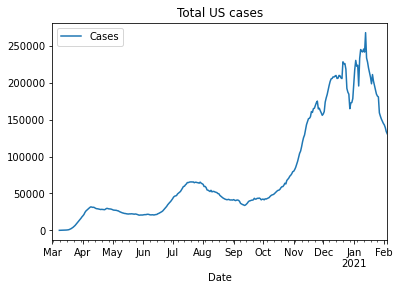

In [4]:
# Display national cases
data.df_covid.pivot_table(index = 'Date', 
                            values = 'Cases', 
                            aggfunc='sum')['2020-03-01':].diff().rolling(7).mean().plot()

plt.title('Total US cases')
plt.show()

In [ ]:
# Show latest unemployment claims
data.df_weekly.pivot_table(index='Date', 
                           columns='State', 
                           values='Initial_claims').sum(axis=1).plot()
plt.ylabel('Claims in M')
plt.title('US total weekly unemployment claims')
plt.show()

In [7]:
# Show latest US unemployment by county
data.us_geo_plot('Unemployment rate')

AttributeError: module 'geopandas' has no attribute 'GeoDataFrame'

In [ ]:
# Show average age
data.us_geo_plot('Mean age')

In [ ]:
states = ['Colorado', 'California', 'New York', 'Tennessee', 'Texas']

pd.pivot_table(data.df_descartes[data.df_descartes['State'].isin(states)],
               index='Date', columns=['State'],
               values='Mobility index')['2020-03-10':].resample('W').mean().plot()

In [ ]:
# Saving the timestamps
data.dates.to_csv(path/'var_dates.csv')

In [ ]:
print('Script complete')